# IMAGINE tutorial 5 -- an almost real IMAGINE pipeline

### Using the LSA magnetic field model and hammurabi X. (without MPI)

Check 
- [Tutorial 1](tutorial_one.ipynb) for the description of the elements of the IMAGINE pipeline.
- [Tutorial 3](tutorial_three.ipynb) describes how to use hammurabi X.

In [1]:
import numpy as np
import logging as log
import healpy as hp

## Classes that store Observables (simulated or measured) and covariance matrices
from imagine import Simulations, Measurements, Covariances
## The likelihood class (obviously the Likelihood element)
from imagine import EnsembleLikelihood

## The LSA field and its factory (one possibilty for the Galaxy-Generator element)
from imagine import BregLSA
from imagine import BregLSAFactory
## The random field component
from imagine import BrndES
from imagine import BrndESFactory
## The simple analytic CRE model
from imagine import CREAna
from imagine import CREAnaFactory
## The YMW16 thermal electron model:
from imagine import TEregYMW16
from imagine import TEregYMW16Factory


## A flat prior
from imagine import FlatPrior
## The toy model simulator (one possibility for the Observable-Generator element)
from imagine import Hammurabi 
## The pyMultiNest sampler (one possibility for the Sampler element)
from imagine import MultinestPipeline
from imagine import DynestyPipeline
## A tool to estimate a covariance matrix from an ensemble of stochastic simulations:
from imagine.tools.covariance_estimator import oas_cov

## visualize posterior with 3rd party corner package (pip install corner)
import corner
import matplotlib
## Mapping internal parameter units to physical units
from imagine.tools.carrier_mapper import unity_mapper
matplotlib.use('Agg')

# call after importing matplotlib
%matplotlib inline

## step 1, prepare mock data

Let's make a very low resolution map of synchrotron total I and Faraday depth from the WMAP model, including a random compnent:

In [2]:
## Set the resolution
nside=2
npix=12*nside**2
## All of the other hammurabi parameters are in here, set up for
##  both a regular and low-res random grid:
xmlpath = './template.xml'
    
## An empty measurement set to define what we want:
trigger = Measurements()
trigger.append(('sync', '23', str(nside), 'I'), np.zeros((1,npix)))  # only I map
trigger.append(('fd', 'nan', str(nside), 'nan'), np.zeros((1,npix)))  # only I map

## This instance of hammurabi is to mock up some fake data:
mocker = Hammurabi(measurements=trigger, xml_path=xmlpath)


observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


Select the models we want to use:

In [3]:
# BregLSA field
paramlist={'b0':3, 'psi0': 27.0, 'psi1': 0.9, 'chi0': 25.0}
breg_lsa = BregLSA(paramlist, 1)

# CREAna field
paramlist = {'alpha': 3.0, 'beta': 0.0, 'theta': 0.0,
             'r0': 5.0, 'z0': 1.0,
             'E0': 20.6, 'j0': 0.0217}  # inactive parameters at default
cre_ana = CREAna(paramlist, 1)

# FEregYMW16 field
paramlist = dict() 
tereg_ymw16 = TEregYMW16(paramlist, 1)

## Random field
paramlist = {'rms': 3., 'k0': 0.5, 'a0': 1.7,
             'k1': 0.5, 'a1': 0.0,
             'rho': 0.5, 'r0': 8., 'z0': 1.}
brnd_es = BrndES(paramlist, 1)

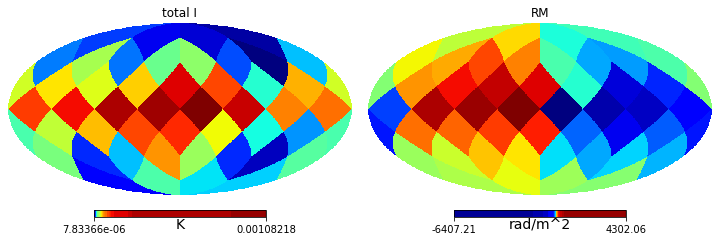

In [4]:
## Generate mock data (run hammurabi)
outputs = mocker([breg_lsa, brnd_es, cre_ana, tereg_ymw16])
## Collect the outputs
mockedI = outputs[('sync', '23', str(nside), 'I')].data
mockedRM = outputs[('fd', 'nan', str(nside), 'nan')].data
dm=np.mean(mockedI)
dv=np.std(mockedI)
## Add some noise that's just proportional to the average sync I by the factor err
err=0.01
dataI = np.vstack([mockedI + np.random.normal(loc=0.,scale=err*dm,size=12*nside**2)])
## Just 0.01*50 rad/m^2 of error for noise.  
dataRM = np.vstack([mockedRM + np.random.normal(loc=0.,scale=err*50.,size=12*nside**2)])

mock_data = Measurements()
mock_data.append(('sync', '23', str(nside), 'I'), dataI)
mock_data.append(('fd', 'nan', str(nside), 'nan'), dataRM)

## Diagonal covariances that only include the noise
mock_cov = Covariances()
mock_cov.append(('sync', '23', str(nside), 'I'), ((err*dm)**2) * np.eye(12*nside**2) )
mock_cov.append(('fd', 'nan', str(nside), 'nan'), ((err*50.)**2) * np.eye(12*nside**2) )

## Get the data back out in a plottable format, ie. undo the vstack with an hstack
matplotlib.rcParams['figure.figsize'] = (10.0, 4.0)
hp.mollview(np.hstack(dataI), norm='hist', cmap='jet',sub=(1,2,1),title="total I",unit='K')
hp.mollview(np.hstack(dataRM), norm='hist', cmap='jet',sub=(1,2,2),title="RM",unit='rad/m^2')

Now let's set up the pipeline as we have done before, but this time with hammurabi as the simulator:

In [5]:
## Use an ensemble to estimate the galactic variance
likelihood = EnsembleLikelihood(mock_data, mock_cov)

## WMAP B-field, vary only b0 and psi0
breg_factory = BregLSAFactory(active_parameters=('b0', 'psi0'))
breg_factory.parameter_ranges = {'b0': (0., 10.), 'psi0': (0., 50.)}
## Random B-field, vary only RMS amplitude
brnd_factory = BrndESFactory(active_parameters=('rms',))
brnd_factory.parameter_ranges = {'rms': (0., 10.)}
## Fixed CR model
cre_factory = CREAnaFactory()
## Fixed FE model
tereg_factory = TEregYMW16Factory()
factory_list = [breg_factory, brnd_factory, cre_factory, tereg_factory]

## Flat prior
prior = FlatPrior()
## Hammurabi simulator
simer = Hammurabi(measurements=mock_data, xml_path=xmlpath)

## Compute 10 realizations at each sample:
ensemble_size=10

## Initialize the pipeline with all of these inputs
pipe = MultinestPipeline(simer, factory_list, likelihood, prior, ensemble_size)
pipe.sampling_controllers = {'n_live_points': 1000,"verbose":False}#,"resume":True} 

## Alternate sampler
#pipe = DynestyPipeline(simer, factory_list, likelihood, prior, ensemble_size)

observable {}
|-->  sync {'cue': '1', 'freq': '23', 'nside': '2'}
|-->  faraday {'cue': '1', 'nside': '2'}


This run will take a long time to converge.  If we want to monitor its progress from another jupyter window, or more importantly, kill it before it's converged and see how it went, then we can also set up a progress reporter.  The `pymultinest` package does this two ways.  If you specify the `outputfiles_basename` to a local directory, then it will write the chains as it samples (the diretory must exist first), and you can read these.  You can also set it to produce regular diagnostics by using its ProgressPlotter().  

If you don't want to run this overnight, skip this cell.  The chains from my interrupted run are included, so the next cells should work anyway.

In [ ]:
import os, pymultinest

if not os.path.isdir("chains"):
    os.mkdir("chains")

## Start a progress job to report every 100 seconds (100*1000ms):
progress=pymultinest.watch.ProgressPlotter(n_params=len(pipe.active_parameters),outputfiles_basename="chains/1-",interval_ms=100000)
progress.start()
## And run it
results=pipe()
progress.stop()

Interrupted after running overnight.  It did not converge, but we can look at the chain of samples it went through to see where it was going:

In [ ]:
## Looking at in progress files shows where it was.  This is
##  the file where the chains are stored:
samples=np.genfromtxt('chains/1-.txt')
##  The first two columns are probability, -2*log likelihood, 
##  and then the parameters in internal [0,1] units:
samples=np.array([samples[:,2]*10.,samples[:,3]*50.,samples[:,4]*10.]).transpose()
samples.shape


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 2), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(131)
plt.plot(samples[:,0])
plt.subplot(132)
plt.plot(samples[:,1],color='r')
plt.subplot(133)
plt.plot(samples[:,2],color='g')


In [ ]:
##  See https://corner.readthedocs.io/en/latest/pages/sigmas.html about contour levels.  
##  "Contours are shown at 0.5, 1, 1.5, and 2 sigma"
##  according to https://pypi.org/project/corner/1.0.1/, 
##  but I want 1, 2, and 3
sigmas=np.array([1.,2.,3.])
levels=1-np.exp(-0.5*sigmas*sigmas)
x=corner.corner(samples,
              labels=['b0','psi0','rms'],
              range=[(1,5),(10.,40.),(1,5)],
              quantiles=[0.05, 0.5, 0.95],  ## These are the vertical lines in the 1D marginalized plots
              show_titles=True,
              title_kwargs={"fontsize": 15},
              color='steelblue',
              truths=[3,27,3],
              truth_color='firebrick',
              plot_contours=True,
              hist_kwargs={'linewidth': 2},
              label_kwargs={'fontsize': 20}
              ,levels=levels  ## replacing defaults (0.5,1,1.5,2 sigma) with 1,2,3
              )


### This ends tutorial 5.